In [1]:
%matplotlib inline


# Video processing, Object detection & Tracking


**Demonstrating the video processing capabilities of Stone Soup**

This notebook will guide you progressively through the steps necessary to:

1. Use the Stone Soup :class:`~.FrameReader` components to open and process video data;
2. Use the :class:`~.TensorFlowBoxObjectDetector` to detect objects in video data, making use of TensorFlow object detection models;
3. Build a :class:`~.MultiTargetTracker` to perform tracking of multiple object in video data.




## Software dependencies
Before we begin with this tutorial, there are a few things that we need to install in order to
proceed.

### FFmpeg
FFmpeg is a free and open-source project consisting of a vast software suite of libraries and
programs for handling video, audio, and other multimedia files and streams. Stone Soup (or more
accurately some of its extra dependencies) make use of FFmpeg to read and output video. Download
links and installation instructions for FFmpeg can be found `here <https://www.ffmpeg.org/download.html>`__.

### TensorFlow
TensorFlow is a free and open-source software library for dataflow and differentiable programming
across a range of tasks, such machine learning. TensorFlow includes an Object Detection API that
makes it easy to construct, train and deploy object detection models, as well as a collection of
pre-trained models that can be used for out-of-the-box inference. A quick TensorFlow installation
tutorial can be found `here <https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html>`__.

### Stone Soup
To perform video-processing using Stone Soup, we need to install some extra dependencies. The
easiest way to achieve this is by running the following commands in a Terminal window:

.. code::

    git clone "https://github.com/dstl/Stone-Soup.git"
    cd Stone-Soup
    python -m pip install -e .[dev,video,tensorflow]

### Pytube
We will also use pytube_ to download a Youtube video for the purposes of this tutorial. In the
same Terminal window, run the following command to install ``pytube``:

.. code::

    pip install pytube



## Using the Stone Soup :class:`~.FrameReader` classes
The :class:`~.FrameReader` abstract class is intended as the base class for Stone Soup readers
that read frames from any form of imagery data. As of now, Stone Soup has two implementations of
:class:`~.FrameReader` subclasses:

1. The :class:`~.VideoClipReader` component, which uses MoviePy_ to read video frames from a file.
2. The :class:`~.FFmpegVideoStreamReader` component, which uses ffmpeg-python_ to read frames from real-time video streams (e.g. RTSP).

In this tutorial we will focus on the :class:`~.VideoClipReader`, since setting up a stream for
the :class:`~.FFmpegVideoStreamReader` is more involved. Nevertheless, the use and interface of
the two readers is mostly identical after initialisation and an example of how to initialise the
later will also be provided



### Download and store the video
First we will download the video that we will use throughout this tutorial. The code snippet
shown below will download the video and save it your working directory as ``sample1.mp4``.



In [2]:
import os
import yt_dlp
VIDEO_FILENAME = 'sample1'
VIDEO_EXTENTION = '.mp4'
VIDEO_PATH = os.path.join(os.getcwd(), VIDEO_FILENAME+VIDEO_EXTENTION)

ydl_opts = {
    'format': 'best',
    'outtmpl': VIDEO_PATH,
}
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['https://www.youtube.com/watch?v=MNn9qKG2UFI'])

[youtube] Extracting URL: https://www.youtube.com/watch?v=MNn9qKG2UFI
[youtube] MNn9qKG2UFI: Downloading webpage
[youtube] MNn9qKG2UFI: Downloading tv client config
[youtube] MNn9qKG2UFI: Downloading tv player API JSON
[youtube] MNn9qKG2UFI: Downloading ios player API JSON
[youtube] MNn9qKG2UFI: Downloading m3u8 information
[info] MNn9qKG2UFI: Downloading 1 format(s): 18
[download] /ws/sample1.mp4 has already been downloaded
[download] 100% of   20.91MiB


### Building the video reader

#### VideoClipReader
We will use the :class:`~.VideoClipReader` class to read and replay the downloaded file. We also
configure the reader to only replay the clip for the a duration of 2 seconds between `00:10` and
`00:12`.



In [3]:
import datetime
from stonesoup.reader.video import VideoClipReader
start_time = datetime.timedelta(minutes=0, seconds=10)
end_time = datetime.timedelta(minutes=0, seconds=12)
frame_reader = VideoClipReader(VIDEO_PATH, start_time, end_time)

It is also possible to apply clip transformations and effects, as per the
`MoviePy documentation <https://zulko.github.io/moviepy/getting_started/effects.html>`_.
The underlying MoviePy :class:`~VideoFileClip` instance can be accessed through the
:attr:`~.VideoClipReader.clip` class property. For example, we can crop out 100 pixels from
the top and left of the frames, as they are read by the reader, as shown below.



In [4]:
from moviepy.video.fx import all
frame_reader.clip = all.crop(frame_reader.clip, 100, 100)
num_frames = len(list(frame_reader.clip.iter_frames()))

#### FFmpegVideoStreamReader
For reference purposes, we also include here an example of how to build a
:class:`~.FFmpegVideoStreamReader`. Let's assume that we have a camera which broadcasts its feed
through a public RTSP stream, under the URL ``rtsp://192.168.55.10:554/stream``. We can build a
:class:`~.FFmpegVideoStreamReader` object to read frames from this stream as follows:

.. code:: python

  in_opts = {'threads': 1, 'fflags': 'nobuffer'}
  out_opts = {'format': 'rawvideo', 'pix_fmt': 'bgr24'}
  stream_url = 'rtsp://192.168.55.10:554/stream'
  video_reader = FFmpegVideoStreamReader(stream_url, input_opts=in_opts, output_opts=out_opts)

.. important::

  Note that the above code is an illustrative example and will not be run.

:attr:`~.FFmpegVideoStreamReader.input_opts` and :attr:`~.FFmpegVideoStreamReader.output_opts`
are optional arguments, which allow users to specify options for the input and output FFmpeg
streams, as documented by `FFmpeg <https://ffmpeg.org/ffmpeg.html#toc-Options>`__ and
ffmpeg-python_.



### Reading frames from the reader
All :class:`~.FrameReader` objects, of which the :class:`~.VideoClipReader` is a subclass,
generate frames in the form of :class:`~.ImageFrame` objects. Below we show an example of how to
read and visualise these frames using `matplotlib`.



Running FrameReader example...
Frame: 10/60
Frame: 20/60
Frame: 30/60
Frame: 40/60
Frame: 50/60
Frame: 60/60


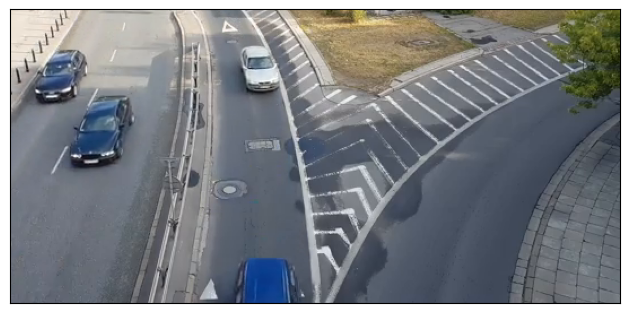

In [5]:
from copy import copy
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np

fig, ax = plt.subplots(num="VideoClipReader output")
artists = []

print('Running FrameReader example...')
for timestamp, frame in frame_reader:
    if not (len(artists)+1) % 10:
        print("Frame: {}/{}".format(len(artists)+1, num_frames))

    # Read the frame pixels
    pixels = copy(frame.pixels)

    # Plot output
    image = Image.fromarray(pixels)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    fig.tight_layout()
    artist = ax.imshow(image, animated=True)
    artists.append([artist])

ani = animation.ArtistAnimation(fig, artists, interval=20, blit=True, repeat_delay=200)
ani.save('video_clip_reader_output.mp4', writer='ffmpeg', fps=30)

## Using the :class:`~.TensorFlowBoxObjectDetector` class
We now continue by demonstrating how to use the :class:`~.TensorFlowBoxObjectDetector` to detect
objects, and more specifically cars, within the frames read in by our ``video_reader``. The
:class:`~.TensorFlowBoxObjectDetector` can utilise both pre-trained and custom-trained TensorFlow
object detection models which generate detection in the form of bounding boxes. In this example,
we will make use of a pre-trained model from the
`TensorFlow detection model zoo <https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md>`_,
but the process of using a custom-trained TensorFlow model is the same.



### Downloading the model
The code snippet shown below is used to download the object detection model that we will feed
into the :class:`~.TensorFlowBoxObjectDetector`, as well as the label file (.pbtxt) which
contains a list of strings used to add the correct label to each detection (e.g. car).

The particular detection algorithm we will use is the Faster-RCNN, with an Inception
Resnet v2 backbone and running in Atrous mode with low proposals, pre-trained on the MSCOCO
dataset.

<div class="alert alert-danger"><h4>Warning</h4><p>**The downloaded model has a size of approximately 500 MB**. Therefore it is advised that you
  run the script on a stable (ideally not mobile) internet connection. The files will only be
  downloaded the first time the script is run. In consecutive runs the code will skip this step,
  provided that ``PATH_TO_MODEL`` and ``PATH_TO_LABELS`` are valid paths.</p></div>



In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Download and extract model
def download_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_file,
                                        untar=True)
    model_dir = pathlib.Path(model_dir)/"saved_model"
    return str(model_dir)

MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_lowproposals_coco_2018_01_28'
PATH_TO_MODEL = download_model(MODEL_NAME)

# Download labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = './mscoco_label_map.pbtxt'

2025-07-29 15:14:44.526238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-29 15:14:44.526287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-29 15:14:44.532052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


672221932/672221932 [==============================] - 28s 0us/step


### Building the detector
Next, we proceed to initialise our detector object. To do this, we require the ``frame_reader``
object we built previously, as well as a path to the (downloaded) ``saved_model`` directory and
label (.pbtxt) file, which we have already defined above under the ``PATH_TO_MODEL`` and
``PATH_TO_LABELS`` variables.

The :class:`~.TensorFlowBoxObjectDetector` object can optionally be configured to digest frames
from the provided reader asynchronously, and only perform detection on the last frame digested,
by setting ``run_async=True``.This is suitable when the detector is applied to readers generating
a live feed (e.g. the :class:`~.FFmpegVideoStreamReader`), where real-time processing is
paramount. Since we are using a :class:`~.VideoClipReader` in this example, we set
``run_async=False``, which is also the default setting.



In [7]:
PATH_TO_MODEL = '/home/user/.keras/datasets/faster_rcnn_inception_resnet_v2_atrous_lowproposals_coco_2018_01_28/faster_rcnn_inception_resnet_v2_atrous_lowproposals_coco_2018_01_28/saved_model'

In [8]:
from stonesoup.detector.tensorflow import TensorFlowBoxObjectDetector

run_async = False                           # Configure the detector to run in synchronous mode
detector = TensorFlowBoxObjectDetector(frame_reader, PATH_TO_MODEL, PATH_TO_LABELS,
                                       run_async=run_async)

### Filtering-out unwanted detections
In this section we showcase how we can utilise Stone Soup :class:`~.Feeder` objects in order to
filter out unwanted detections. One example of feeder we can use is the
:class:`~.MetadataValueFilter`, which allows us to filter detections by applying a custom
operator on particular fields of the :attr:`~.Detection.metadata` property of detections.

Each detection generated by :class:`~.TensorFlowBoxObjectDetector` carries the following
:attr:`~.Detection.metadata` fields:

 - ``raw_box``: The raw bounding box containing the normalised coordinates ``[y_0, x_0, y_1, x_1]``, as generated by TensorFlow.
 - ``class``: A dict with keys ``id`` and ``name`` relating to the id and name of the detection class.
 - ``score``: A float in the range ``(0, 1]`` indicating the detector's confidence.

Detection models trained on the MSCOCO dataset, such as the one we downloaded, are able to detect
90 different classes of objects (see the `downloaded .pbtxt file <https://github.com/tensorflow/models/blob/master/research/object_detection/data/mscoco_label_map.pbtxt>`_
for a full list). Instead, as we discussed at the beginning of the tutorial, we wish to limit the
detections to only those classified as cars. This can be done as follows:



In [9]:
from stonesoup.feeder.filter import MetadataValueFilter
detector = MetadataValueFilter(detector, 'class', lambda x: x['name'] == 'car')

Continuing, we may want to filter out detections which have a low confidence score:



In [10]:
detector = MetadataValueFilter(detector, 'score', lambda x: x > 0.1)

Finally, we observed that the detector tends to incorrectly generate detections which are much
larger the the size we expect for a car. Therefore, we can filter out those detections by only
allowing ones whose width is less the 20\% of the frame width (i.e. ``x_1-x_0 < 0.2``):



In [11]:
detector = MetadataValueFilter(detector, 'raw_box', lambda x: x[3]-x[1] < 0.2)

You are encouraged to comment out any/all of the above filter definitions and observe the
produced output.



### Reading and visualising detections
Detections generated by the :class:`~.TensorFlowBoxObjectDetector` have a 4-dimensional
:attr:`~.Detection.state_vector` in the form of a bounding boxes that captures the area of the
frame where an object is detected. Each bounding box is represented by a vector of the form
``[x, y, w, h]``, where ``x, y`` denote the relative pixel coordinates of the top-left corner,
while ``w, h`` denote the relative width and height of the bounding box. Below we show an example
of how to read and visualise these detections using `matplotlib`.



Running TensorFlowBoxObjectDetector example... Be patient...


W0000 00:00:1753816627.349143   17974 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -949 } dim { size: -950 } dim { size: -951 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -106 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -106 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "AuthenticAMD" model: "240" frequency: 3194 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -106

Frame: 10/60
Frame: 20/60


KeyboardInterrupt: 

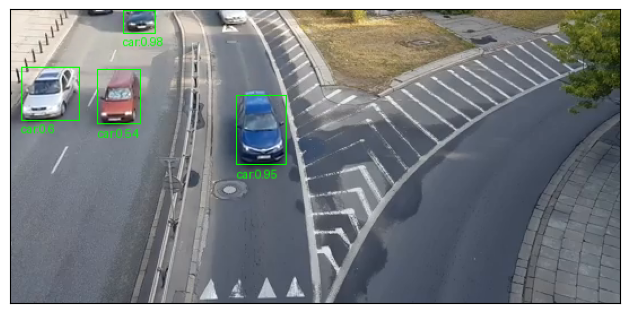

In [12]:
import numpy as np
from PIL import ImageDraw


def draw_detections(image, detections, show_class=False, show_score=False):
    """ Draw detections on an image

    Parameters
    ----------
    image: :class:`PIL.Image`
        Image on which to draw the detections
    detections: : set of :class:`~.Detection`
        A set of detections generated by :class:`~.TensorFlowBoxObjectDetector`
    show_class: bool
        Whether to draw the class of the object. Default is ``False``
    show_score: bool
        Whether to draw the score of the object. Default is ``False``

    Returns
    -------
    : :class:`PIL.Image`
        Image with detections drawn
    """
    draw = ImageDraw.Draw(image)
    for detection in detections:
        x0, y0, w, h = np.array(detection.state_vector).reshape(4)
        x1, y1 = (x0 + w, y0 + h)
        draw.rectangle([x0, y0, x1, y1], outline=(0, 255, 0), width=1)
        class_ = detection.metadata['class']['name']
        score = round(float(detection.metadata['score']),2)
        if show_class and show_score:
            draw.text((x0,y1 + 2), '{}:{}'.format(class_, score), fill=(0, 255, 0))
        elif show_class:
            draw.text((x0, y1 + 2), '{}'.format(class_), fill=(0, 255, 0))
        elif show_score:
            draw.text((x0, y1 + 2), '{}'.format(score), fill=(0, 255, 0))

    del draw
    return image


fig2, ax2 = plt.subplots(num="TensorFlowBoxObjectDetector output")
artists2 = []
print("Running TensorFlowBoxObjectDetector example... Be patient...")
for timestamp, detections in detector:
    if not (len(artists2)+1) % 10:
        print("Frame: {}/{}".format(len(artists2)+1, num_frames))

    # Read the frame pixels
    frame = frame_reader.frame
    pixels = copy(frame.pixels)

    # Plot output
    image = Image.fromarray(pixels)
    image = draw_detections(image, detections, True, True)
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)
    fig2.tight_layout()
    artist = ax2.imshow(image, animated=True)
    artists2.append([artist])

ani2 = animation.ArtistAnimation(fig2, artists2, interval=20, blit=True, repeat_delay=200)
ani2.save('tensorflow_box_object_detector_output.mp4', writer='ffmpeg', fps=30)

## Constructing a Multi-Object Video Tracker
In this final segment of the tutorial we will see how we can use the above demonstrated
components to perform tracking of multiple objects within Stone Soup.

### Defining the state-space models
Transition Model
****************
We begin our definition of the state-space models by defining the hidden state
$\mathrm{x}_k$, i.e. the state that we wish to estimate:

\begin{align}\mathrm{x}_k = [x_k, \dot{x}_k, y_k, \dot{y}_k, w_k, h_k]\end{align}

where $x_k, y_k$ denote the pixel coordinates of the top-left corner of the bounding box
containing an object, with $\dot{x}_k, \dot{y}_k$ denoting their respective rate of change,
while $w_k$ and $h_k$ denote the width and height of the box, respectively.

We assume that $x_k$ and $y_k$ move with nearly :class:`~.ConstantVelocity`, while
$w_k$ and $h_k$ evolve according to a :class:`~.RandomWalk`.Using these assumptions,
we proceed to construct our Stone Soup :class:`~.TransitionModel` as follows:



In [53]:
from stonesoup.models.transition.linear import (CombinedLinearGaussianTransitionModel,
                                                ConstantVelocity, RandomWalk)
t_models = [ConstantVelocity(20**2), ConstantVelocity(20**2), RandomWalk(20**2), RandomWalk(20**2)]
transition_model = CombinedLinearGaussianTransitionModel(t_models)

#### Measurement Model
Continuing, we define the measurement state $\mathrm{y}_k$, which follows naturally from
the form of the detections generated by the :class:`~.TensorFlowBoxObjectDetector` we previously
discussed:

\begin{align}\mathrm{y}_k = [x_k, y_k, w_k, h_k]\end{align}

We make use of a 4-dimensional :class:`~.LinearGaussian` model as our :class:`~.MeasurementModel`,
whereby we can see that the individual indices of $\mathrm{y}_k$ map to indices `[0,2,4,5]`
of the 6-dimensional state $\mathrm{x}_k$:



In [54]:
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(ndim_state=6, mapping=[0, 2, 4, 5],
                                   noise_covar=np.diag([1**2, 1**2, 3**2, 3**2]))

### Defining the tracker components
With the state-space models defined, we proceed to build our tracking components

#### Filtering
Since we have assumed Linear-Gaussian models, we will be using a Kalman Filter to perform
filtering of the underlying single-target densities. This is done by making use of the
:class:`~.KalmanPredictor` and :class:`~.KalmanUpdater` classes, which we define below:



In [55]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

In [56]:
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

<div class="alert alert-info"><h4>Note</h4><p>For more information on the above classes and how they operate you can refer to the Stone
  Soup tutorial on
  `using the Kalman Filter <https://stonesoup.readthedocs.io/en/latest/auto_tutorials/01_KalmanFilterTutorial.html>`_.</p></div>

#### Data Association
We utilise a :class:`~.DistanceHypothesiser` to generate hypotheses between tracks and
measurements, where :class:`~.Mahalanobis` distance is used as a measure of quality:



In [57]:
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
hypothesiser = DistanceHypothesiser(predictor, updater, Mahalanobis(), 10)

Continuing the :class:`~.GNNWith2DAssigment` class is used to perform fast joint data association,
based on the Global Nearest Neighbour (GNN) algorithm:



In [58]:
from stonesoup.dataassociator.neighbour import GNNWith2DAssignment
data_associator = GNNWith2DAssignment(hypothesiser)

<div class="alert alert-info"><h4>Note</h4><p>For more information on the above classes and how they operate you can refer to the
  `Data Association - clutter <https://stonesoup.readthedocs.io/en/latest/auto_tutorials/05_DataAssociation-Clutter.html>`_
  and `Data Association - Multi-Target Tracking <https://stonesoup.readthedocs.io/en/latest/auto_tutorials/06_DataAssociation-MultiTargetTutorial.html>`_
  tutorials.</p></div>



#### Track Initiation
For initialising tracks we will use a :class:`~.MultiMeasurementInitiator`, which allows our
tracker to tentatively initiate tracks from unassociated measurements, and hold them within the
initiator until they have survived for at least 10 frames. We also define a
:class:`~.UpdateTimeStepsDeleter` deleter to be used by the initiator to delete tentative tracks
that have not been associated to a measurement in the last 3 frames.



In [59]:
from stonesoup.types.state import GaussianState
from stonesoup.types.array import CovarianceMatrix, StateVector
from stonesoup.initiator.simple import MultiMeasurementInitiator
from stonesoup.deleter.time import UpdateTimeStepsDeleter
prior_state = GaussianState(StateVector(np.zeros((6,1))),
                            CovarianceMatrix(np.diag([100**2, 30**2, 100**2, 30**2, 100**2, 100**2])))
deleter_init = UpdateTimeStepsDeleter(time_steps_since_update=3)
initiator = MultiMeasurementInitiator(prior_state, deleter_init, data_associator, updater,
                                      measurement_model, min_points=10)

#### Track Deletion
For confirmed tracks we used again a :class:`~.UpdateTimeStepsDeleter`, but this time configured
to delete tracks after they have not bee associated to a measurement in the last 15 frames.



In [60]:
deleter = UpdateTimeStepsDeleter(time_steps_since_update=15)

<div class="alert alert-info"><h4>Note</h4><p>For more information on the above classes and how they operate you can refer to the Stone
  `Initiators & Deleters <https://stonesoup.readthedocs.io/en/latest/auto_tutorials/09_Initiators_&_Deleters.html>`_
  tutorial.</p></div>

### Building the tracker
Now that we have defined all our tracker components we proceed to build our multi-target tracker:



In [61]:
from stonesoup.tracker.simple import MultiTargetTracker
tracker = MultiTargetTracker(
    initiator=initiator,
    deleter=deleter,
    detector=detector,
    data_associator=data_associator,
    updater=updater,
)

### Running the tracker



Running MultiTargetTracker example... Be patient...
Frame: 10/60
Frame: 20/60
Frame: 30/60
Frame: 40/60
Frame: 50/60
Frame: 60/60


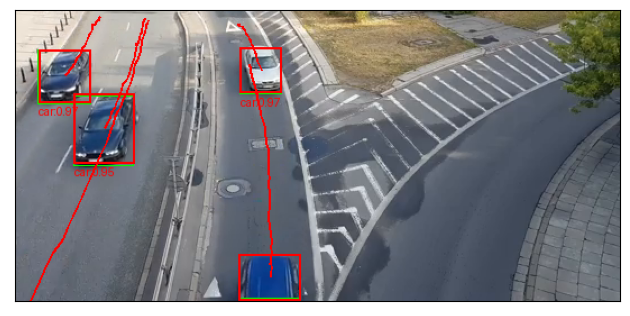

In [62]:
def draw_tracks(image, tracks, show_history=True, show_class=True, show_score=True):
    """ Draw tracks on an image

    Parameters
    ----------
    image: :class:`PIL.Image`
        Image on which to draw the tracks
    detections: : set of :class:`~.Tracks`
        A set of tracks generated by our :class:`~.MultiTargetTracker`
    show_history: bool
        Whether to draw the trajectory of the track. Default is ``True``
    show_class: bool
        Whether to draw the class of the object. Default is ``True``
    show_score: bool
        Whether to draw the score of the object. Default is ``True``

    Returns
    -------
    : :class:`PIL.Image`
        Image with tracks drawn

    """
    draw = ImageDraw.Draw(image)
    for track in tracks:
        bboxes = np.array([np.array(state.state_vector[[0, 2, 4, 5]]).reshape(4)
                           for state in track.states])
        x0, y0, w, h = bboxes[-1]
        x1 = x0 + w
        y1 = y0 + h
        draw.rectangle([x0, y0, x1, y1], outline=(255, 0, 0), width=2)

        if show_history:
            pts = [(box[0] + box[2] / 2, box[1] + box[3] / 2) for box in bboxes]
            draw.line(pts, fill=(255, 0, 0), width=2)

        class_ = track.metadata['class']['name']
        score = round(float(track.metadata['score']), 2)
        if show_class and show_score:
            draw.text((x0, y1 + 2), '{}:{}'.format(class_, score), fill=(255, 0, 0))
        elif show_class:
            draw.text((x0, y1 + 2), '{}'.format(class_), fill=(255, 0, 0))
        elif show_score:
            draw.text((x0, y1 + 2), '{}'.format(score), fill=(255, 0, 0))
    return image


fig3, ax3 = plt.subplots(num="MultiTargetTracker output")
fig3.tight_layout()
artists3 = []
print("Running MultiTargetTracker example... Be patient...")
for timestamp, tracks in tracker:
    if not (len(artists3) + 1) % 10:
        print("Frame: {}/{}".format(len(artists3) + 1, num_frames))

    # Read the detections
    detections = detector.detections

    # Read frame
    frame = frame_reader.frame
    pixels = copy(frame.pixels)

    # Plot output
    image = Image.fromarray(pixels)
    image = draw_detections(image, detections)
    image = draw_tracks(image, tracks)
    ax3.axes.xaxis.set_visible(False)
    ax3.axes.yaxis.set_visible(False)
    fig3.tight_layout()
    artist = ax3.imshow(image, animated=True)
    artists3.append([artist])
ani3 = animation.ArtistAnimation(fig3, artists3, interval=20, blit=True, repeat_delay=200)
ani3.save('multi_target_tracker_output.mp4', writer='ffmpeg', fps=30)